In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras_applications.resnet import ResNet50
from keras import backend as K 

In [3]:
folder_benign_train = 'drive/MyDrive/Colab Notebooks/data/sdata/train/benign'
folder_malignant_train = 'drive/MyDrive/Colab Notebooks/data/sdata/train/malignant'

folder_benign_test = 'drive/MyDrive/Colab Notebooks/data/sdata/test/benign'
folder_malignant_test = 'drive/MyDrive/Colab Notebooks/data/sdata/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [4]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1]
y_train = y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test = X_test[s2]
y_test = y_test[s2]

In [5]:
print("Shape of X_train: ", X_train.shape) # one image constitutes to (224, 224, 3) and we have 2637 total images in training set
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (1337, 224, 224, 3)
Shape of y_train:  (1337,)
Shape of X_test:  (280, 224, 224, 3)
Shape of y_test:  (280,)


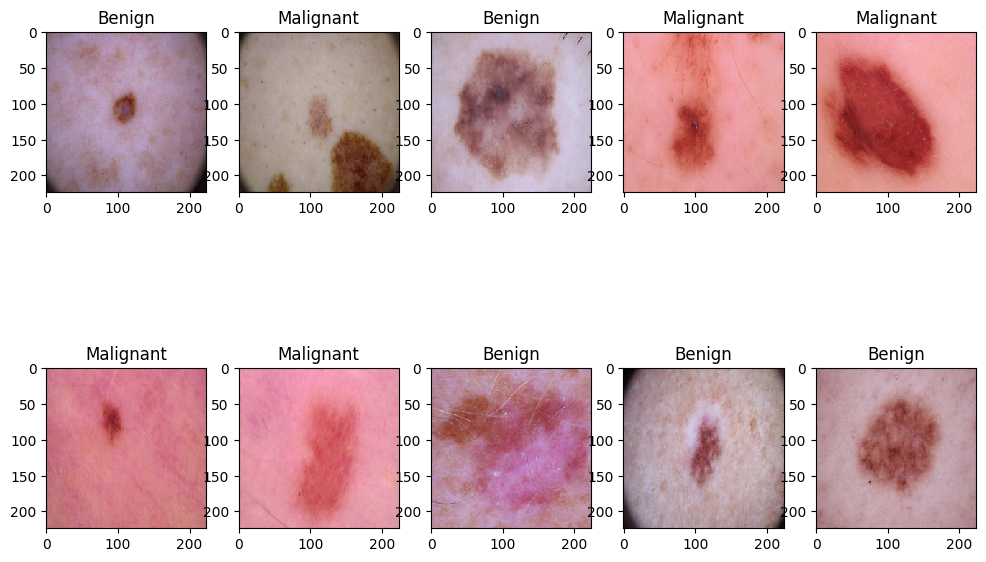

In [6]:
fig = plt.figure(figsize=(12,8))
columns = 5
rows = 2

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i].all() == 1:
        ax.title.set_text('Benign')
    if y_train[i].any()==0:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()




In [7]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)
type(y_train)

numpy.ndarray

In [8]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [9]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    
    optimizer = Adam(lr=0.001)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model




In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [11]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 34: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 39: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 44: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 49: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [12]:
learning_rate_reductions = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [13]:
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reductions]
         )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       


Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


In [14]:
y_pred = np.argmax(model.predict(X_test), axis=-1)


9/9 [==============================] - 1s 57ms/step


In [15]:
print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

0.8035714285714286


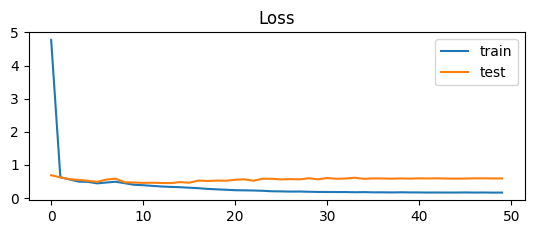

In [17]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

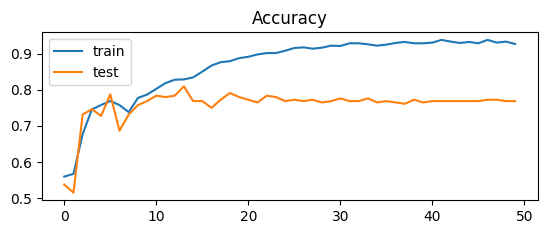

In [18]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
 
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(np.argmax(y_test, axis=1), y_pred)
print('Precision: %f' % precision)
recall = recall_score(np.argmax(y_test, axis=1), y_pred)
print('Recall: %f' % recall)
f1 = f1_score(np.argmax(y_test, axis=1), y_pred)
print('F1 score: %f' % f1)
matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(matrix)

Accuracy: 0.803571
Precision: 0.743363
Recall: 0.763636
F1 score: 0.753363
[[141  29]
 [ 26  84]]


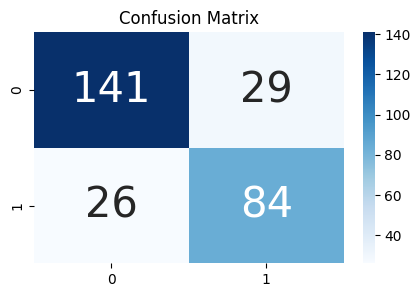

In [31]:
import seaborn as sns
plt.figure(figsize=(5,3))
ax=plt.axes()
df_cm=matrix
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues")
ax.set_title('Confusion Matrix')
plt.show()